# 04 Simple decision trees

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA

In [2]:
# Some global variables
features_basepath = '/data/ml_course/04_Applied_Machine_Learning_2/11_Course_project/'
max_depth = 3

In [3]:
# Load data
def load_data(features_basepath, features_file, one_hot_encoding=False):
    with np.load(os.path.join(features_basepath, features_file), allow_pickle=False) as npz_file:
        data = dict(npz_file.items())
        
    X = data['data']
    if one_hot_encoding:
        y = data['labels']
    else:
        y = np.where(data['labels'] == 1)[1]
    names = data['names']
    filenames = data['filenames']
    
    return X, y, names, filenames 

In [4]:
X_tr, y_tr, names, fn_tr = load_data(features_basepath, 'Swissroads_train.npz', one_hot_encoding=False)
X_va, y_va, _, fn_va = load_data(features_basepath, 'Swissroads_valid.npz', one_hot_encoding=False)
X_te, y_te, _, fn_te = load_data(features_basepath, 'Swissroads_test.npz', one_hot_encoding=False)

## Decision tree

In [5]:
# Create decision tree
dt = DecisionTreeClassifier(
    criterion='gini', max_depth=max_depth, random_state=0)

# Fit decision tree
dt.fit(X_tr, y_tr)

# Get score
acc_DT = 100*dt.score(X_te, y_te)
print('Accuracy with a max depth of {:d}: {:.2f}%'.format(max_depth, acc_DT))

Accuracy with a max depth of 3: 66.00%


The accuracy with a max depth of 3 is worse than that of the best nearest neighbor

## DT plot

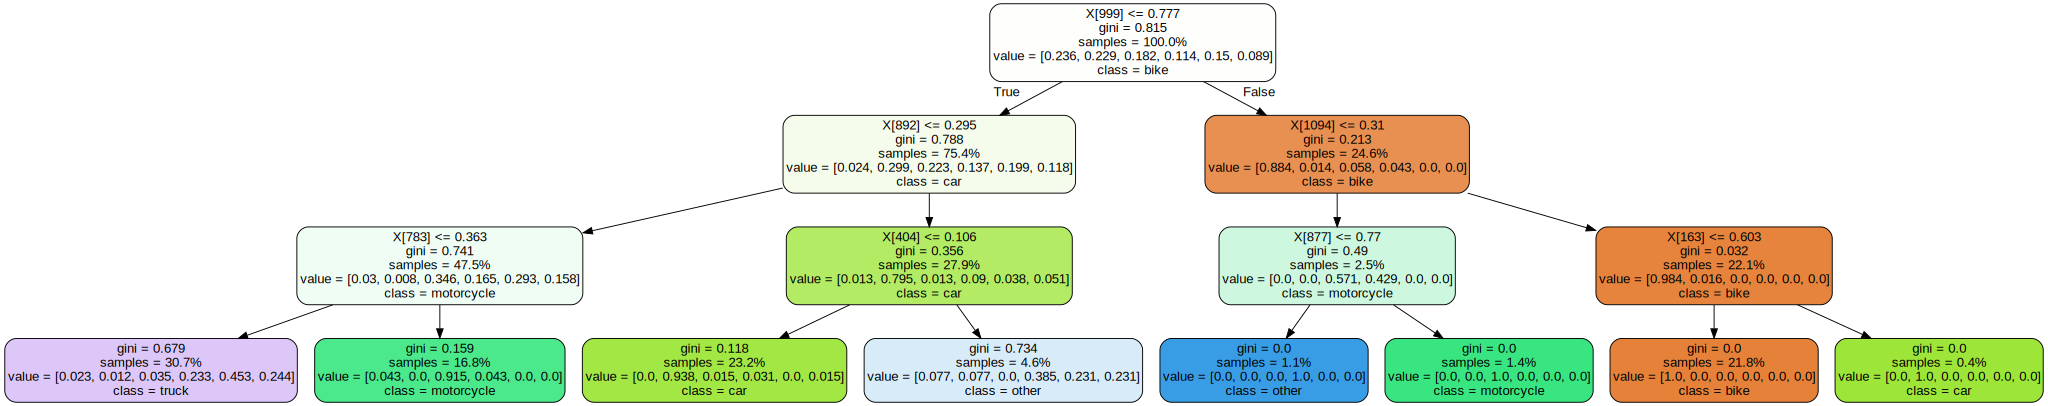

In [6]:
# Export decision tree
dot_data = export_graphviz(
    dt, out_file=None,
    class_names=names,
    filled=True, rounded=True, proportion=True   
)

# Display decision tree
graphviz.Source(dot_data)

## DT with PCA

In [7]:
n_PCAs = np.arange(1, 281)
accs_PCA = []
for n_PCA in n_PCAs:
    # Create PCA transformer
    pca = PCA(n_components=n_PCA)
    pca.fit(X_tr)
    
    # Apply PCA to data
    X_tr_PCA = pca.transform(X_tr)
    X_va_PCA = pca.transform(X_va)
        
    # Fit decision tree
    dt.fit(X_tr_PCA, y_tr)
    
    # Get score
    acc_PCA = 100*dt.score(X_va_PCA, y_va)
    accs_PCA.append(acc_PCA)
    # print('Accuracy with first {} PCA components: {:.2f}%'.format(n_PCA, acc_PCA))

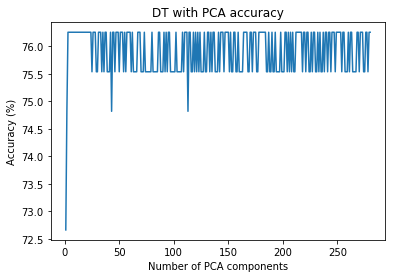

In [8]:
plt.plot(n_PCAs, accs_PCA)
plt.xlabel('Number of PCA components')
plt.ylabel('Accuracy (%)')
plt.title('DT with PCA accuracy')
plt.show()

In [9]:
acc_max = np.max(accs_PCA)
n_PCA_max = n_PCAs[np.argmax(accs_PCA)]
print('Maximum accuracy on the validation set {:.2f}% with {} PCA components'.format(acc_max, n_PCA_max))

Maximum accuracy on the validation set 76.26% with 3 PCA components


In [10]:
# Check results on test set
X_te_PCA = pca.transform(X_te)
# Get score
acc_PCA_test = 100*dt.score(X_te_PCA, y_te)
print('Test accuracy {:.2f}%'.format(acc_PCA_test))

Test accuracy 74.00%


We do get better results if we reduce the number of dimensions. The best result is when we reduce the number of dimensions to 3.

## Store results

In [11]:
df_acc = pd.DataFrame({'model': ['DT', 'DT with PCA'], 'test_accuracy': [acc_DT, acc_PCA_test]})
df_acc.to_csv('acc_DT.csv', index=False)